# Fashion MNIST using Linear Layers with JAX

- toc: true
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png



My main objective here is to develop a Keras like API for JAX, and use it on the so-called Fashion MNIST dataset.

The type of model we're looking to build can be represented in Keras, as follows:

```python
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(128, activation=keras.activations.relu),
  keras.layers.Dense(10, activation=keras.activations.softmax)                          
])

model.compile(
    loss=keras.losses.sparse_categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)
```

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax 
import tensorflow as tf

from typing import Tuple, List, Any


2022-07-13 13:57:52.214672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/bin:/usr/local/lib:


## Grabbing the Data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print(f'Number of training samples = {len(y_train)}') 
print(f'Number of test samples = {len(y_test)}')

Number of training samples = 60000
Number of test samples = 10000


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

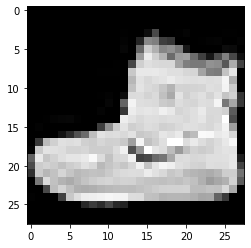

In [4]:
X = X_train[0]
np.set_printoptions(linewidth=200)
plt.imshow(X, cmap='gray')
print(X)

In [5]:
X_train, X_test = X_train / 255.0, X_test / 255.0

## Model API

In [6]:

class Model: 
    def forward(self, params, X, y):
        raise NotImplementedError
    def compile(self, loss, optimizer, metrics, params):
        self.loss = loss 
        self.optimizer = optimizer 
        self.metrics = metrics 
        self.params = params
    def fit(self, X_train, y_train):
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(100).batch(32)
        
        loss = self.loss 
        optimizer = self.optimizer 
        params = self.params
        # Get the parameters from the model ...

        # Taken from optax tutorial code ...
        opt_state = self.optimizer.init(params)
        
        def step(params, opt_state, batch, labels):
            loss_value, grads = jax.value_and_grad(loss)(params, self.forward, batch, labels)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value

        # one epoch
        for i, (batch, labels) in enumerate(train_dataset.as_numpy_iterator()):
            loss_value, _ = jax.value_and_grad(loss)(params, self.forward, batch, labels)
            params, opt_state, loss_value = step(params, opt_state, batch, labels)
            if i % 100 == 0:
                print(f'step {i}, loss: {loss_value}')

        
    

In [7]:
class Network: pass
class Function: pass

In [23]:
class Dense(Network):
    w: jnp.ndarray 
    b: jnp.ndarray
    input_shape: Tuple[int]

    def __init__(self, num_features, activation=jax.nn.relu):
        self.num_features = num_features 
        self.activation = activation
    def setup(self, input_shape, seed=1234):
        self.input_shape = input_shape
        shape = (self.num_features, self.input_shape)
        key = jax.random.PRNGKey(seed)

        self.w = jax.random.normal(key, shape) * jnp.sqrt(2.0 / input_shape)
        self.b = jnp.zeros(self.num_features)
    @property
    def params(self):
        return {'w': self.w, 'b': self.b}
    def __call__(self, x):
        return self.activation(jnp.dot(self.w, x) + self.b) 



In [9]:
def flatten_Dense(layer: Dense):
    params = (layer.w, layer.b)
    extra_stuff = {
        'num_features': layer.num_features,
        'activation': layer.activation,
        'input_shape': layer.input_shape
    }

    return params, extra_stuff

def unflatten_Dense(extra_stuff, params) -> Dense:
    layer = Dense(num_features=extra_stuff['num_features'], activation=extra_stuff['activation'])
    layer.w = params[0]
    layer.b = params[1]
    layer.input_shape = extra_stuff['input_shape']
    return layer
    
jax.tree_util.register_pytree_node(
    Dense, flatten_Dense, unflatten_Dense    
)

In [10]:
l = Dense(10)
l.setup(input_shape=3)
jax.tree_util.tree_flatten(l)

([DeviceArray([[-0.77767605, -1.6257328 ,  0.8562147 ],
               [ 0.2656164 , -0.91964155,  0.33663693],
               [ 1.6229765 ,  0.22684166, -1.2966851 ],
               [ 0.23250706,  1.2053852 ,  0.23687442],
               [-0.3150987 ,  0.7502025 ,  1.0367401 ],
               [-0.76967674,  0.45772657, -1.1808424 ],
               [-1.3382986 , -0.559498  ,  0.28776148],
               [ 0.20669922, -1.457551  ,  0.82045996],
               [-0.27901036,  0.01738252,  0.06019784],
               [ 0.00342628,  0.37365758,  0.5010083 ]], dtype=float32),
  DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)],
 PyTreeDef(CustomNode(<class '__main__.Dense'>[{'num_features': 10, 'activation': <jax._src.custom_derivatives.custom_jvp object at 0x7fae45f02e50>, 'input_shape': 3}], [*, *])))

In [11]:
class Flatten(Function):
    input_shape: Tuple[int]
    num_features: int 
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.num_features= np.prod(input_shape) 
    def __call__(self, x):
        return jnp.reshape(x, -1)


In [12]:

def flatten_Flatten(layer: Flatten):
    params = []
    extra_stuff = { 'input_shape': layer.input_shape }
    return params, extra_stuff

def unflatten_Flatten(extra_stuff, params) -> Dense:
    return Flatten(input_shape=extra_stuff['input_shape'])
    
jax.tree_util.register_pytree_node(
    Flatten, flatten_Flatten, unflatten_Flatten    
)

In [13]:
l = Flatten((28,28))
jax.tree_util.tree_flatten(l)

([],
 PyTreeDef(CustomNode(<class '__main__.Flatten'>[{'input_shape': (28, 28)}], [])))

In [24]:
class Sequential(Network):
    layers: List
    params: Any 
    input_shape: Tuple[int]
    def __init__(self, *layers):
        self.layers = layers
        self.params = []
    def setup(self, input_shape):
        self.input_shape = input_shape
        input_shape = self.input_shape
        for layer in self.layers:
            if isinstance(layer, Network):
                layer.setup(input_shape)
                self.params.append(layer.params)
                input_shape = layer.num_features
            elif isinstance(layer, Flatten): 
                input_shape = layer.num_features   
    def __call__(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output
    

In [15]:
print(jax.tree_util.tree_flatten([{'a': 1, 'b': 5}, {'c': 7}]))

([1, 5, 7], PyTreeDef([{'a': *, 'b': *}, {'c': *}]))


In [16]:
# Need to revise this inorder to get the parameters back into the model
def flatten_Sequential(model: Sequential):
    params = model.params
    extra_stuff = {'layers': model.layers}
    return params, extra_stuff

def unflatten_Sequential(extra_stuff, params) -> Dense:
    layers = extra_stuff['layers']
    model = Sequential(*layers)
    model.setup(input_shape=extra_stuff['input_shape'])
    return model
    
jax.tree_util.register_pytree_node(
    Sequential, flatten_Sequential, unflatten_Sequential    
)

In [25]:
model = Sequential(
    Flatten(input_shape=(28, 28)),
    Dense(128, activation=jax.nn.relu),
    Dense(10, activation = jax.nn.softmax)   
)
model.setup(input_shape=(28, 28))


In [34]:
model.params
l = jax.tree_util.tree_flatten(model.params)

DeviceArray([[-0.00503162, -0.11710759,  0.05479915, ..., -0.08478684, -0.01258498, -0.0106819 ],
             [-0.02930931, -0.06342698, -0.07211312, ..., -0.06885359,  0.05326153, -0.00705581],
             [-0.01227331, -0.08667105,  0.01609307, ..., -0.07811324,  0.01763334,  0.00712718],
             ...,
             [-0.00622975, -0.08475864, -0.0552172 , ...,  0.05935797,  0.0743569 , -0.00805993],
             [ 0.10648176, -0.02254054, -0.03166944, ..., -0.01719078,  0.00110678,  0.0392415 ],
             [-0.037219  , -0.02834321,  0.00695875, ..., -0.0069246 ,  0.04329436,  0.07048796]], dtype=float32)

## Loss Function

In Equinox and Treex, loss functions in which the model is the first argument are jitted.  I can't get this to work now (I think), because I'm not 
converting my module instantiation to a PyTree.  This seems to be the secret: Treex and Equinox found a way to convert their versions of modules to pytrees.

In [11]:
a = Dense(10)
a.setup(10)

{'weights': DeviceArray([[ 0.4955482 ,  0.31323454, -0.16431722, -0.1778598 , -0.37309384, -0.27601704,  0.6786144 , -0.83603036, -0.37456733, -0.38529804],
              [-0.51664037,  0.23452531,  0.39358795, -0.81366616, -0.30139554,  0.12572241, -0.27614236,  0.04341735,  1.0657046 ,  1.0121646 ],
              [-0.02414936,  0.7453478 , -0.28615332, -0.196245  ,  0.33748606,  0.9765807 , -0.12719607,  0.329515  , -0.4071786 ,  0.12246487],
              [-0.68219537,  0.03157214,  0.57286984, -0.44964808,  0.3903244 ,  0.06237474, -0.3355008 ,  1.0056379 , -0.29798067, -0.05773307],
              [-0.98469573, -0.32533288,  0.1938749 , -0.286879  , -0.3740165 , -1.1384696 , -1.29627   ,  0.1767095 , -0.39158744, -0.80702335],
              [ 0.45510042,  0.4024033 , -0.0216945 ,  0.2830267 ,  0.0508937 , -0.0493672 ,  0.16445382,  0.7305577 ,  0.59985423, -0.28474948],
              [ 0.06098274, -0.40136126,  0.16223292, -0.4865787 ,  0.04620648, -0.25004682, -0.24693362, -0.0843

In [14]:
@jax.jit #- this fails because model is not a pytree
def loss(model, X, y):
    # Need to one-bot encode input labels, recall that MNIST has 10 classes, 0-9
    y_one_hot = jax.nn.one_hot(y, 10).astype(jnp.float32)
    logits = jax.vmap(model)(X) 
    # calculate loss for each sample in minibatch
    #loss = optax.softmax_cross_entropy(logits, y_one_hot)
    # average the losses for each sample in minibatch
    #loss = loss.mean()
    loss = logits.mean()
    return loss

In [19]:
# parameters pulled from model, this seems really clunky ...
def cross_entropy_loss(params, forward, X, y):
    # Need to one-bot encode input labels, recall that MNIST has 10 classes, 0-9
    y_one_hot = jax.nn.one_hot(y, 10).astype(jnp.float32)
    logits = jax.vmap(forward, in_axes=(None, 0))(params, X) 
    # calculate loss for each sample in minibatch
    loss = optax.softmax_cross_entropy(logits, y_one_hot)
    # average the losses for each sample in minibatch
    loss = loss.mean() 
    return loss

In [15]:
model = Dense(10)
model.setup(10)

model.w
loss(model, np.random.randn(5, 10), [1,0,2,3,1])

DeviceArray(0.70658493, dtype=float32)

In [34]:
model = Sequential(
    Flatten(input_shape=(28, 28)),
    Dense(128, activation=jax.nn.relu),
    Dense(10, activation = jax.nn.softmax)   
)


init_params = model.setup(input_shape=(28, 28))

loss(model, np.random.randn(5, 28, 28), [1,0,2,3,1])



TypeError: Argument '<__main__.Sequential object at 0x7f1eabc21eb0>' of type <class '__main__.Sequential'> is not a valid JAX type.

In [762]:
model.forward(init_params, np.random.rand(28, 28))

DeviceArray([0.02157694, 0.09008522, 0.01330612, 0.14697005, 0.03000481, 0.31934047, 0.08668316, 0.07532562, 0.19995402, 0.01675361], dtype=float32)

In [763]:
cross_entropy_loss(init_params, model.forward, np.random.randn(2, 28, 28), [1, 2])

DeviceArray(2.388558, dtype=float32)

In [764]:

model.compile(loss=cross_entropy_loss, optimizer = optax.adam(learning_rate=1e-3), metrics = ['accuracy'], params=init_params)
model.fit(X_train, y_train)

step 0, loss: 2.3042030334472656
step 100, loss: 1.7702372074127197
step 200, loss: 1.8559722900390625
step 300, loss: 1.8455866575241089
step 400, loss: 1.6030317544937134
step 500, loss: 1.7808022499084473
step 600, loss: 1.7045600414276123
step 700, loss: 1.6650400161743164
step 800, loss: 1.6782312393188477
step 900, loss: 1.759960651397705
step 1000, loss: 1.7251852750778198
step 1100, loss: 1.7144274711608887
step 1200, loss: 1.5780982971191406
step 1300, loss: 1.5931434631347656
step 1400, loss: 1.7018799781799316
step 1500, loss: 1.7146620750427246
step 1600, loss: 1.6924097537994385
step 1700, loss: 1.626793622970581
step 1800, loss: 1.6654064655303955


## Training Loop

The training loop tunes the model parameters for a specified number of epochs.  For now the parameters are adjusted once per epoch, after the entire dataset is consumed by the model.  

## Performance Curve

Let's see the trend in the loss function.

## Conclusion



In [41]:
X = np.random.randn(10, 3)
w = np.random.randn(5, 3)

In [42]:
np.dot(X, np.transpose(w))

array([[ 0.95615652, -0.60910943,  0.47719404,  0.50628421, -0.57886369],
       [ 3.09498684,  1.70024379, -1.01957485,  2.25813896, -0.37952626],
       [-3.67871561, -0.1351104 ,  0.04294664, -1.84479421,  0.98852387],
       [-1.00596024,  0.46315551,  0.67104569,  3.13116358, -1.09329311],
       [ 2.07878921,  1.88358723, -1.42939824,  0.84352964,  0.39912581],
       [ 2.91327168, -1.07647233,  0.73089571,  1.0445742 , -1.1687821 ],
       [ 1.03321149,  0.51671102,  0.70734573,  4.30933842, -1.72017219],
       [-2.73799462, -1.54710401,  1.83484434,  1.17423297, -1.08464385],
       [-1.6715637 , -2.74092988,  1.91974295, -1.18807747, -0.68628707],
       [ 1.21170605,  0.15311168, -0.1815407 ,  0.30359954, -0.13915325]])

In [44]:
def lin(x): return jnp.dot(w, x)

yy = jax.vmap(lin)(X)
print(yy)

[[ 0.9561565  -0.6091094   0.47719404  0.50628424 -0.5788637 ]
 [ 3.0949867   1.7002438  -1.0195749   2.258139   -0.37952614]
 [-3.6787155  -0.13511032  0.04294658 -1.8447943   0.9885239 ]
 [-1.0059603   0.46315545  0.67104566  3.1311636  -1.093293  ]
 [ 2.0787892   1.8835871  -1.4293982   0.8435297   0.39912578]
 [ 2.9132717  -1.0764723   0.7308957   1.044574   -1.1687821 ]
 [ 1.0332114   0.516711    0.7073457   4.309338   -1.7201722 ]
 [-2.7379947  -1.547104    1.8348444   1.174233   -1.0846438 ]
 [-1.6715636  -2.7409298   1.919743   -1.1880776  -0.686287  ]
 [ 1.2117062   0.15311167 -0.1815407   0.3035995  -0.13915324]]
